In [1]:
import os
Root = "/home/durgababu/Desktop/music/Traeffik"
os.chdir(Root)

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from matplotlib import style
style.use('fivethirtyeight')

2023-05-15 08:27:48.525699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/durgababu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-15 08:27:48.525810: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Assigning Path for Dataset

In [3]:
data_dir = '/home/durgababu/Desktop/music/Traeffik'
train_path = 'Train'
test_path = 'Test'
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [4]:
os.getcwd()

'/home/durgababu/Desktop/music/Traeffik'

In [5]:
Num_categories = len(os.listdir(train_path))

In [6]:
Num_categories

43

In [7]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
    
}

## Visualizing The Dataset

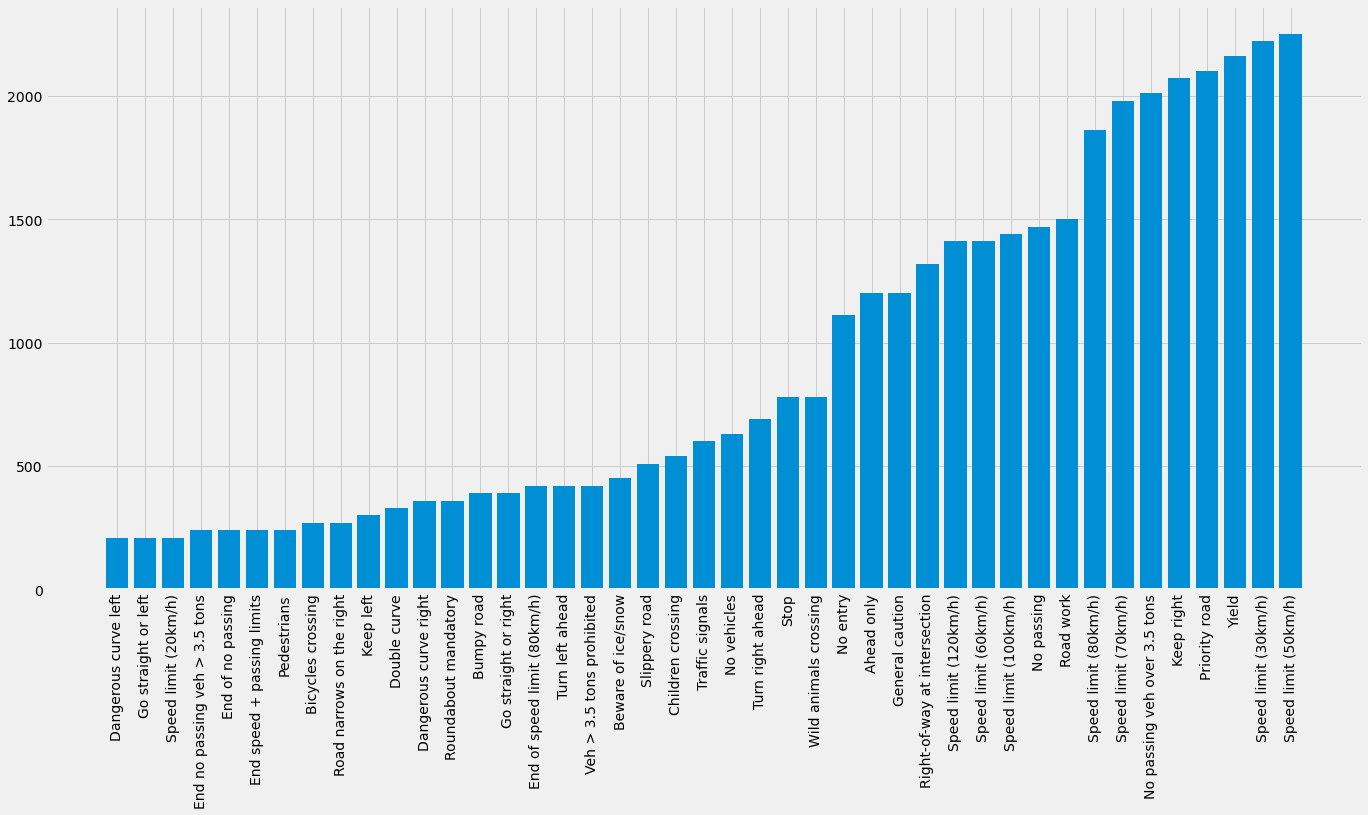

In [8]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

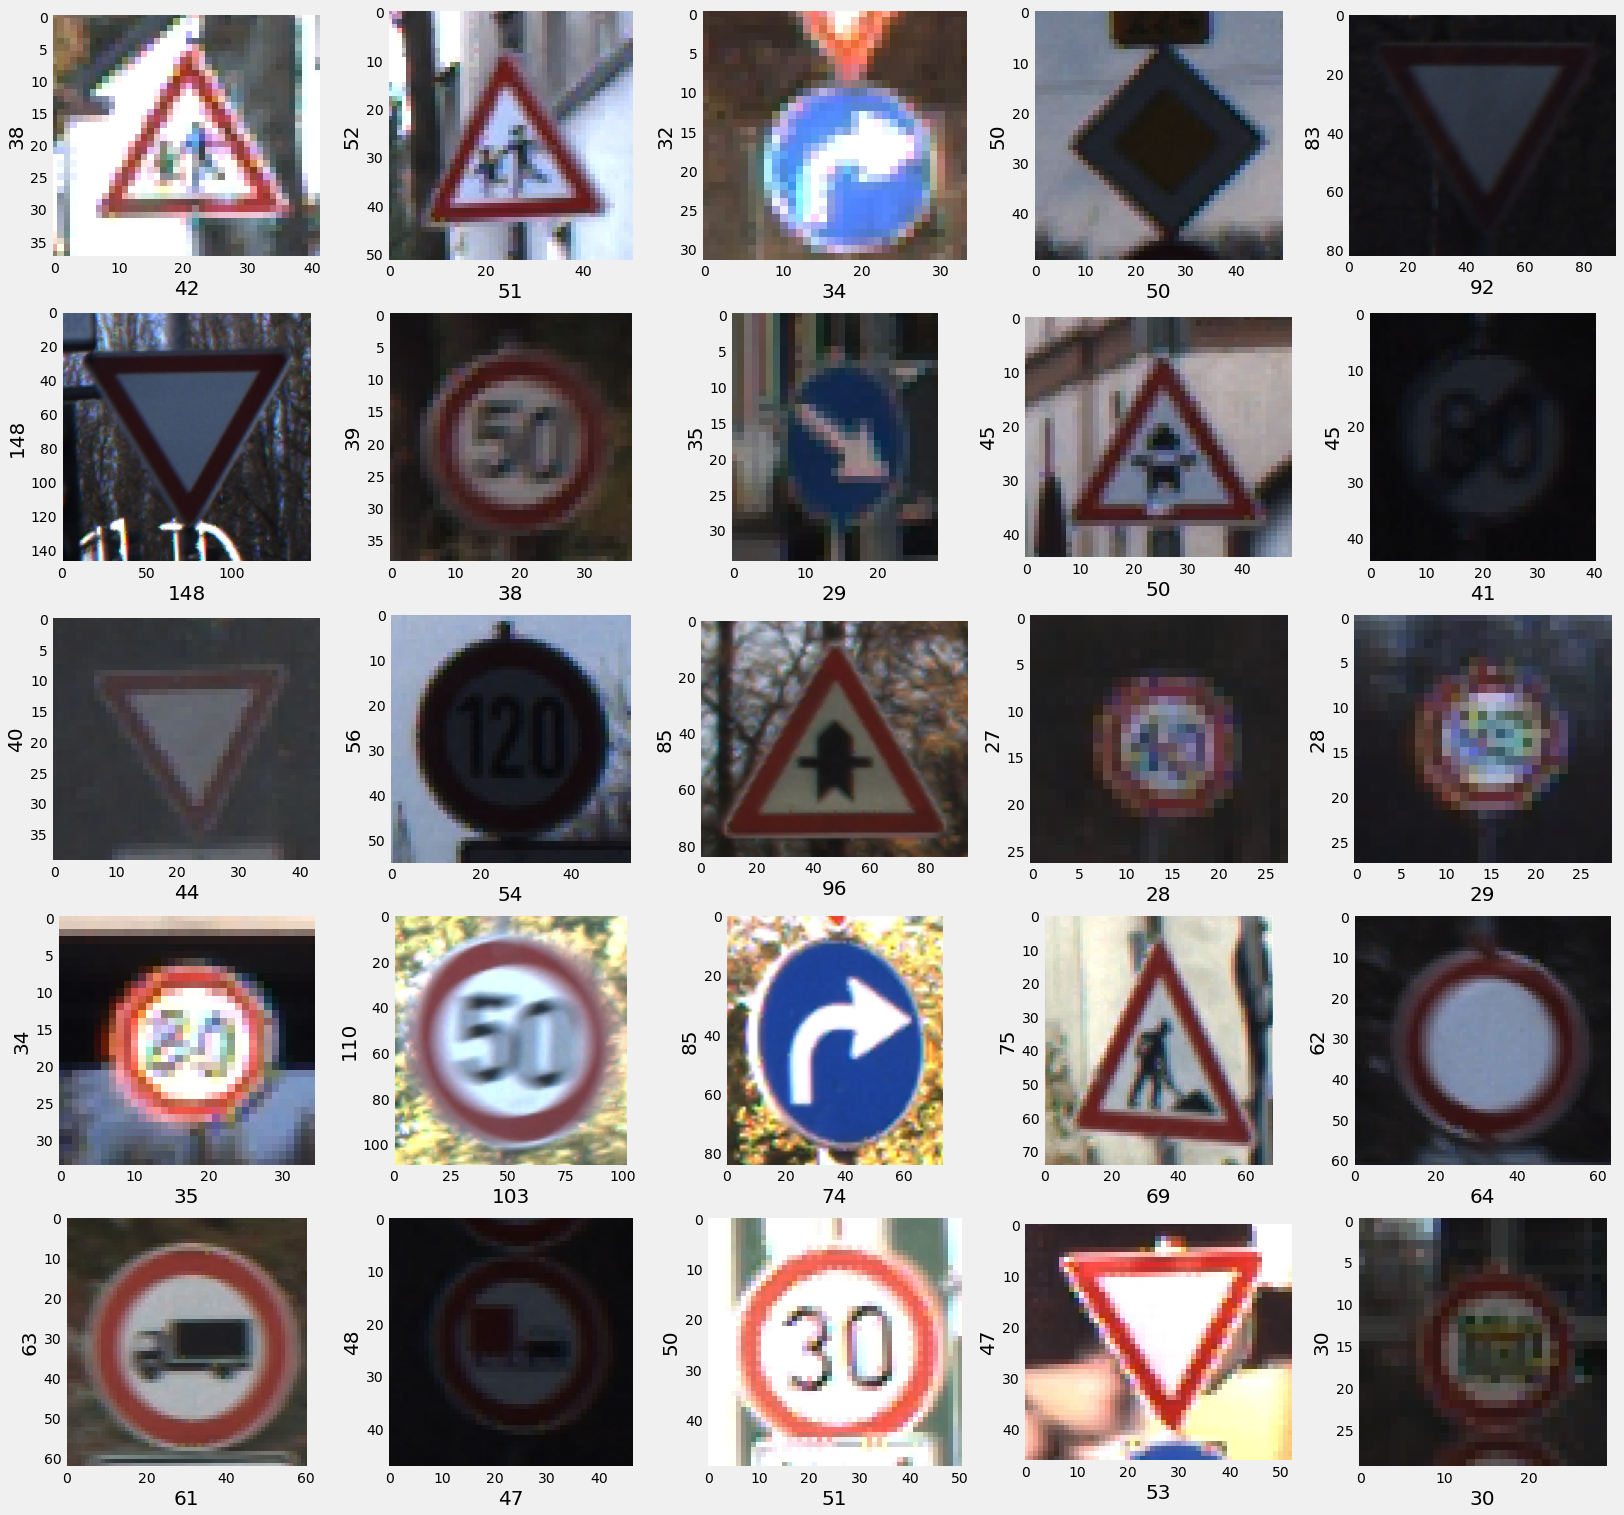

In [9]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [10]:
image_data = []
image_labels = []

for i in range(Num_categories):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)


 # Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape) 


(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [13]:
y_train = keras.utils.to_categorical(y_train, Num_categories)
y_val = keras.utils.to_categorical(y_val, Num_categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [14]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

2023-05-15 08:32:43.244079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/durgababu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-15 08:32:43.244371: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-15 08:32:43.244542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DELL): /proc/driver/nvidia/version does not exist
2023-05-15 08:32:43.290231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:

learning_rate = 0.001
epochs = 30

opt = Adam(learning_rate = learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Augmenting the data and training the model


In [17]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode=("nearest"))
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


2023-05-15 08:34:14.782644: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17981568 exceeds 10% of free system memory.
2023-05-15 08:34:14.784344: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17981568 exceeds 10% of free system memory.
2023-05-15 08:34:14.848182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24920064 exceeds 10% of free system memory.
2023-05-15 08:34:14.848456: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24920064 exceeds 10% of free system memory.
2023-05-15 08:34:14.867145: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19559232 exceeds 10% of free system memory.


858/858 [==============================] - 83s 89ms/step - loss: 1.1143 - accuracy: 0.7033 - val_loss: 0.0995 - val_accuracy: 0.9659
Epoch 2/30
858/858 [==============================] - 70s 82ms/step - loss: 0.1772 - accuracy: 0.9467 - val_loss: 0.0510 - val_accuracy: 0.9852
Epoch 3/30
858/858 [==============================] - 70s 81ms/step - loss: 0.1062 - accuracy: 0.9670 - val_loss: 0.0473 - val_accuracy: 0.9844
Epoch 4/30
858/858 [==============================] - 70s 81ms/step - loss: 0.0818 - accuracy: 0.9752 - val_loss: 0.0193 - val_accuracy: 0.9947
Epoch 5/30
858/858 [==============================] - 69s 81ms/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.0116 - val_accuracy: 0.9969
Epoch 6/30
858/858 [==============================] - 69s 81ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0091 - val_accuracy: 0.9966
Epoch 7/30
858/858 [==============================] - 68s 80ms/step - loss: 0.0511 - accuracy: 0.9846 - val_loss: 0.0189 - val_accuracy: 0.9938
Epo

In [18]:
model.save("model.h5")

In [19]:
model.save_weights("/home/durgababu/Desktop/music/Traeffik")

In [20]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standa

## Evaluating the model

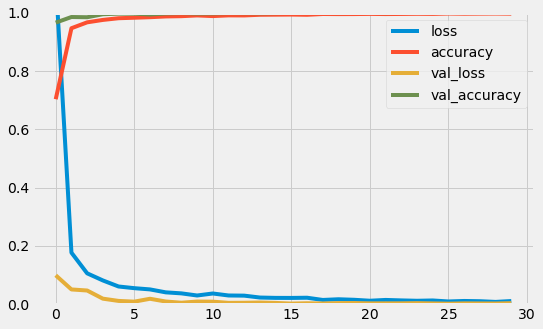

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [21]:
from keras.models import Sequential, load_model
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
import numpy as np

test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

IMG_HEIGHT = 30
IMG_WIDTH = 30

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

model = load_model('model.h5')

# get the probability of each class
pred_prob = model.predict(X_test)

# get the class with the highest probability
pred = np.argmax(pred_prob, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)


Test Data accuracy:  98.12351543942994


## Visualizing the confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot:>

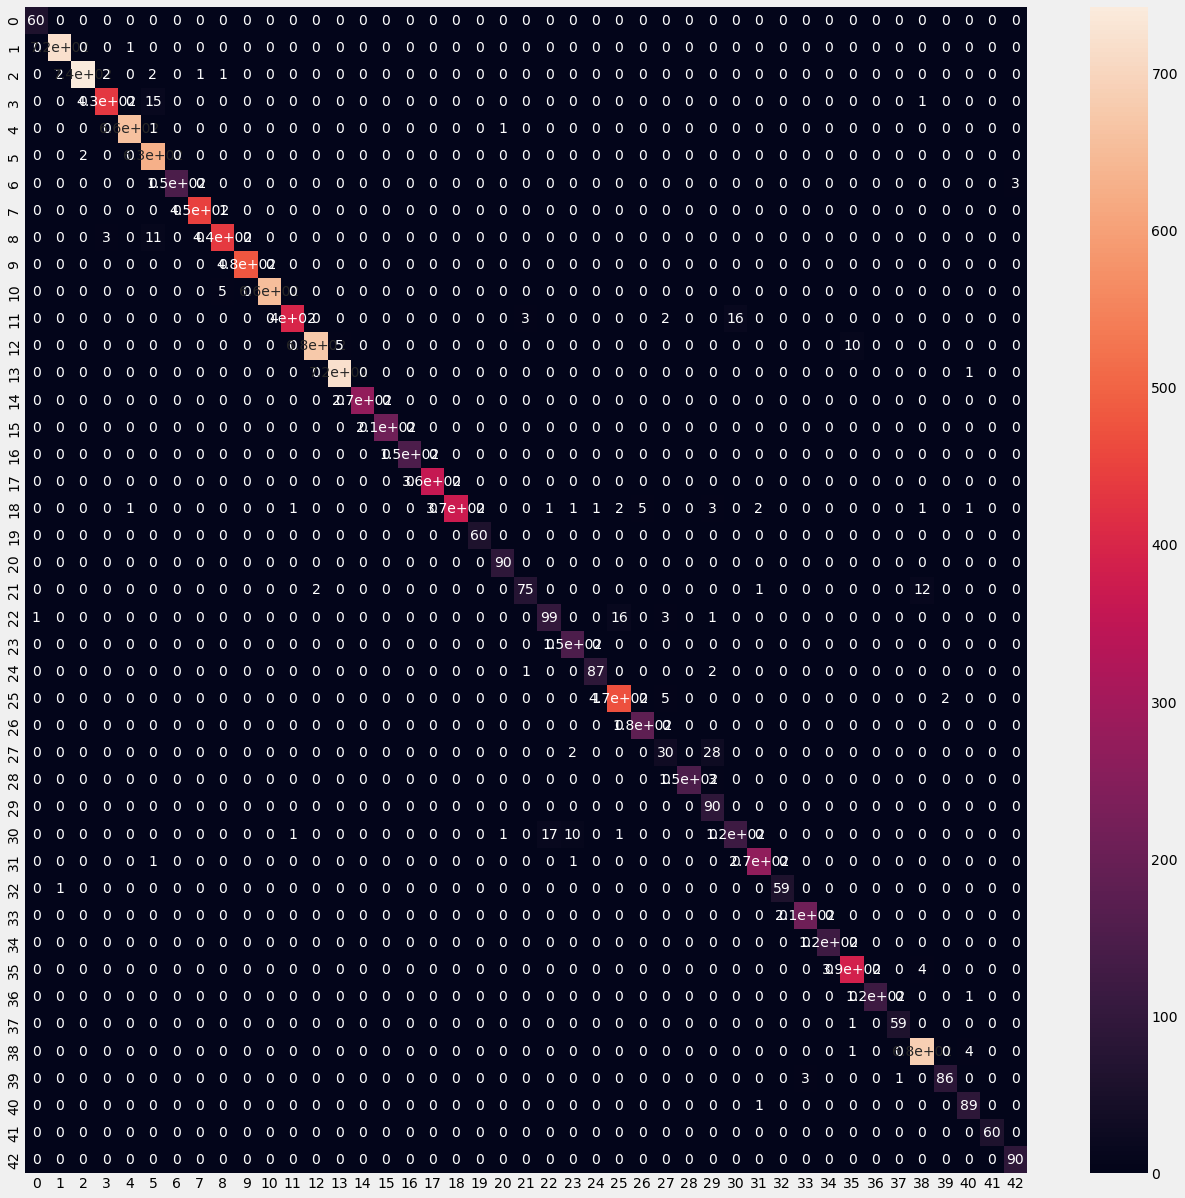

In [24]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       1.00      0.99      0.99       750
           3       0.99      0.96      0.98       450
           4       1.00      1.00      1.00       660
           5       0.95      1.00      0.98       630
           6       1.00      0.98      0.99       150
           7       1.00      1.00      1.00       450
           8       0.98      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      0.95      0.97       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

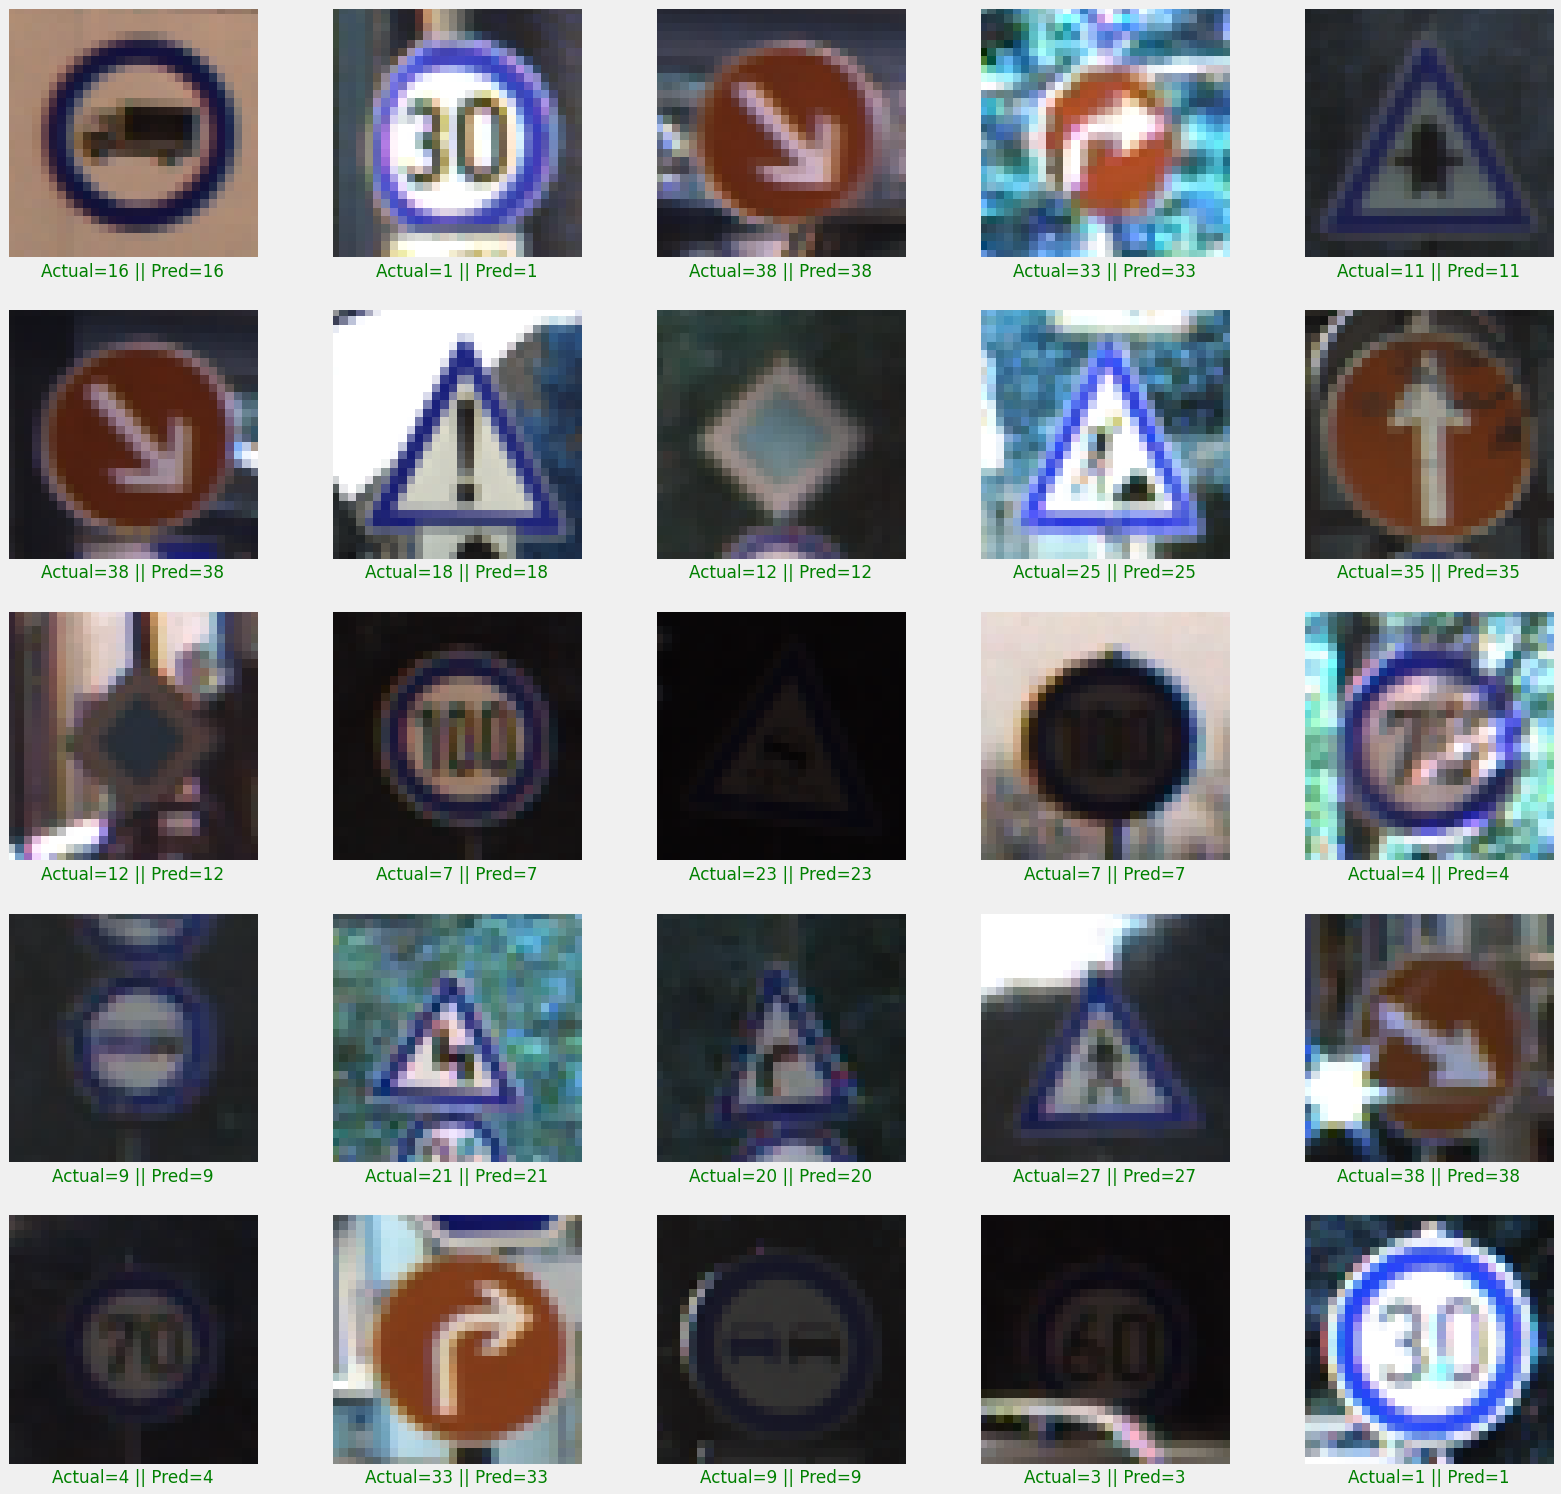

In [26]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [27]:
ls

 clientApp.py                   Procfile            Test.csv
 Dockerfile                     __pycache__/        Traffic.h5
'Docker_setup (1).pdf'          README.md           traffic_signs_project.ipynb
 Emotion_Classification.ipynb   requirements1.txt   Train/
 inputImage.jpg                 requirements.txt    Train.csv
 manifest.yml                   runtime.txt         Untitled1.ipynb
 model.h5                       templates/          Untitled.ipynb
 Model_training.ipynb           test/               utils/
 predict.py                     Test/


In [29]:
import cv2
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/home/durgababu/Desktop/music/Traeffik/Test/00001.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

1